# Language Processing with **_Markov Chains & Hidden Markov Models_**


## Language Detection

### Problem Statement

There are three languages: A, B and C. Each language uses the same set of symbols: "A, o, e, t, p, g, and k." However, each language uses the symbols differently. In each of these languages we can model everything as P(next symbol | current symbol) with Markov Chains.


### Data preparation

In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, homogeneity_score
from hmmlearn.hmm import MultinomialHMM

In [2]:
symbol_dir = 'symbol'

symbol_files = listdir(symbol_dir)

symbols = []
test_symbols = []

files = []

for file in symbol_files:
    with open(symbol_dir + '\\' + file) as f:
        if 'test' not in file:  # the train files don't seem to have labels, so just excluding them
            files.append(file)
            symbols.append(f.read())
        else:
            test_symbols.append(f.read())

In [3]:
seed = 1456418

full_df = (pd.DataFrame(pd.Series(files).str.split('-').tolist()).rename({2: 'language'}, axis=1)
    .assign(string=symbols)[['string', 'language']])

train_df, test_df = train_test_split(full_df, test_size=0.1, random_state=seed)

## Training

The first step to make a prediction for a Markov chain is to generate an $n\times n$ matrix $C$ (with $n$ being the number of unique states), where $C_{ij}$ is the number of times state $i$ transitions to state $j$. Then, we would calculate a transition matrix which would convert the counts into probabilities, where each element in the transition matrix is given by $T_{ij} = \frac{C_{ij}}{\sum_{i=1}^n C_{ij}}$, i.e., the probability of transitioning to state $j$ give we're in state $i$ (meaning $i$th column sums up to 1). Additionally, we need to calculate the vector of initial distributions $\pi$, so that $\pi_i$ is the probability of $i$th state to be the first one in the sequence (for $i \in 1...n$).

In order to make a prediction, we first (in `get_likelihood()`) calculate the likelihood of the given sequence of states given each of the Markov models (languages). To do that, we would first create a count matrix for the sequence (where $C_{ij}$ is the number of times state $i$ transitions to state $j$), and then we would use it to calculate the likelihoods for each of the Markov models as follows: $\begin{aligned}[t]
P(sequence|model) 
    &= P(seq_1|model) \cdot P(seq_2|seq_1, model) \cdot ... \cdot P(seq_{n-1}|seq_n, model) \\
    &= \pi_{s_1} \cdot T_{s_1s_2} \cdot T_{s_2s_3} \cdot ... T_{s_{n-1}s_n} \\
    &= \pi_{s_1} \cdot \prod_i \prod_j T_{ij}^{C_{ij}}
\end{aligned}$

where $seq_n$ is the $n$th state in the sequence, $p_{s_1}$ is the initial probability of the first state in the given sequence to occur in the model, and $T_{ij}^{C_{ij}}$ is the probability of each transition in the sequence to occur in that model, raised to the power of the number of times it appears in the sequence.

Then, in `get_posteriors()`, to finally get the probability of each model given the sequence, $P(model|sequence)$, we apply Bayes theorem as: $P(model_k|sequence) = \frac{P(sequence|model_k)P(model_k)}{\sum_k P(sequence|model_k)}$, where $P(model_k)$ is the prior (assumed to be flat). 

To make the final prediction (in `predict()`), we simply take the index of the model whose posterior is largest and return it as the most probable source of the sequence.


In [4]:
def get_transition_counts(string: str):
    """
    Returns a transition dataframe based on given string,
    Where df['b']['a'] is the number of transitions from 'a' to 'b'.
    """
    df = pd.DataFrame(list(string))
    return (df.assign(old_state=df[0].shift(-1))  # shift one back to get old state
            .assign(new_state=1)  # to count transitions in groupby
            .groupby([0, 'old_state']).count()
            .unstack().fillna(0)  # unstack into wide format
            .droplevel(0, axis=1)  # remove multi-level indexing
            .transpose())  # so that new state is rows and old state is columns


def get_transition_matrix(list_of_strings, symbols=None):
    """
    Returns a transition matrix of a list of strings
    """
    if symbols is None:
        symbols = np.sort(np.unique(list(pd.Series(list_of_strings).sum())))
    # Initialize empty matrix with 0s
    transition_matrix = pd.DataFrame(0, index=pd.Series(symbols, name='new_state'),
                                     columns=pd.Series(symbols, name='old_state'))
    for string in list_of_strings:
        transition_matrix = transition_matrix.add(get_transition_counts(string), fill_value=0)

    return transition_matrix.div(transition_matrix.sum(axis=0), axis=1).fillna(0)  # make sure sums to 1 in each row)


def get_initial_distribution(list_of_strings, symbols=None):
    """
    Returns a Series where index is each of the unique symbols found in strings,
    and values are their relative frequencies in the beginning of strings (sums to 1);
    If `symbols` is passed, ensures all symbols are in result, even if not found (with value 0)
    """
    unique, counts = np.unique([string[0] for string in list_of_strings], return_counts=True)
    if symbols is not None:
        missing_symbols = list(set(symbols) - set(unique))
        unique = np.hstack([unique, missing_symbols])
        counts = np.hstack([counts, [0] * len(missing_symbols)])
    dist = pd.Series(counts, index=unique)
    return dist.sort_index() / dist.sum()


def get_likelihood(string, initial_distribution, transition_matrix):
    """Returns the probability of string given the initial distribution and transition matrix of a language"""
    return initial_distribution[string[0]] * np.product(np.product(transition_matrix ** get_transition_counts(string)))


def get_posteriors(string, initial_distributions, transition_matrices, priors=None):
    """
    Returns posteriors of the string being generated by each of the languages,
    If `priors` is None, assumes flat prior.
    """
    if priors is None:
        priors = np.full(len(initial_distributions), 1) / len(initial_distributions)
    likelihoods = [get_likelihood(string, id, tm) for id, tm in zip(initial_distributions, transition_matrices)]
    return priors * likelihoods / sum(likelihoods)  # Bayes theorem!


def predict(*args, **kwargs):
    """Returns the index of the language with maximum posterior"""
    return np.argmax(get_posteriors(*args, **kwargs))


In [5]:
transition_matrices = []
initial_distributions = []
for lang in train_df.language.unique():
    strings = train_df[train_df.language == lang].string
    transition_matrices.append(get_transition_matrix(strings))
    initial_distributions.append(get_initial_distribution(strings))

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # display only last 3 digits
transition_matrices[1]  # langB

old_state,A,e,g,k,o,p,t
new_state,,,,,,,
A,0.618,0.061,0.090,0.050,0.069,0.044,0.068
e,0.053,0.609,0.066,0.053,0.055,0.088,0.071
g,0.074,0.053,0.588,0.062,0.050,0.085,0.081
k,0.056,0.077,0.069,0.588,0.060,0.044,0.058
o,0.069,0.055,0.064,0.082,0.620,0.073,0.063
p,0.084,0.066,0.048,0.079,0.077,0.593,0.066
t,0.046,0.079,0.074,0.085,0.069,0.073,0.593


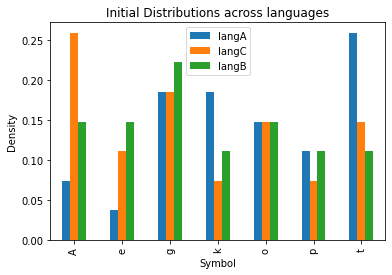

In [7]:
languages = train_df.language.unique()
pd.DataFrame(initial_distributions, index=languages).transpose().plot.bar()
plt.ylabel('Density')
plt.xlabel('Symbol')
plt.title('Initial Distributions across languages')
plt.show()

## Testing

In [8]:
# list of 0, 1 or 2 - classes (indices of languages)
predictions = []
for string, true_lang in zip(test_df.string, test_df.language):
    predictions.append(predict(string, initial_distributions, transition_matrices))

test_df.assign(prediction=languages[predictions])

,string,language,prediction
17,ogogogogopopeppepokegogekogepegogAgAgepetteAtg...,langA,langA
31,AoeoAoeoAtetegeoegAteoegAoetAgtAtAoeoeoAoAgAoe...,langB,langB
33,oetAoAtApoAoegAtetetAgAoAtAoAptAgtooeAgegAtAoA...,langB,langB
35,oeooAeoeoetAtAtAteteteeeoepoAgAggAtteoeoAtgete...,langB,langB
5,kogAptegAtAkkepApAtkApetttgegAkekegokApoAketep...,langA,langA
60,ppoooootttkkkttoppppAAeeopppekkkgggtttttttkkAA...,langC,langC
72,ooooooooAAAAookeeAkkkkoooppgggppotteekkgeepptt...,langC,langC
26,pAkApotpeketptkpotkeekAgopAApgAetgeketAkAtpgAk...,langA,langA
73,ttttAAAAAttAAppopppkkkeeeokkttgteppppppgttkkAA...,langC,langC


In [9]:
# convert true languages to their indices
true_languages = pd.Series(range(len(languages)), index=languages)[test_df.language]

print('Test accuracy:', accuracy_score(true_languages, predictions))

Test accuracy: 1.0


In [10]:
# Posterior distributions of the unlabeled tests

# Suppress scientific notation
np.set_printoptions(suppress=True)

posteriors = []
for string in test_symbols:
    posteriors.append(get_posteriors(string, initial_distributions, transition_matrices))

pd.DataFrame(posteriors, index=test_symbols, columns=('P(' + languages + ')'))

,P(langA),P(langC),P(langB)
pppooootgAookggggtttopAtttkkkeeggeeeeAAAgtkoAkkkkkooppppttppppppgppteoooooottkttttkkkktAAApgookkkkkp,0.000,0.333,0.000
gooooAAAAAAAAAkkkkkkooooAAAeppppppgeeeeepAAppeektetttgggogptttttttkppAAAApetAeegggtttteetttttppAAAAA,0.000,0.333,0.000
ekogoAgkepokogoppAttpAttgeekApegepApotpAAtpetgAtpopAttpAppAtkokettkgAttggokoogApppepogeApopogetpokog,0.333,0.000,0.000
AtAgegegegAgegetoAtetAogAooAoeAtegAgeotAoAgoetAteAteoegoeogetekoAoegAoegAtegAgeotAtAoAtetAtgeggAtAto,0.000,0.000,0.333
popoktgopogettpegAtkegotkogettpApepApegtgApeogokokApetkAgegokpepketpotttpAtkopepototpApettgotokotgok,0.333,0.000,0.000
okopottogttpetgopopotkepeppAgAgetpotpAtgookettgoketkokAgAttpgopAgtkAggAgekottgokAkopApAkopAtgtttpokp,0.333,0.000,0.000
kteoeoeoAoteoAgeoetoegAgeoekgeteoegetetAgeAoAttAtAteoAtetotAoAoeooegegAoetgeoAtegtAteteoAtAgegAgeAoA,0.000,0.000,0.333
tgAkoggAggAtpetkpAgegAgkepepookepepekogokogetkekekekegegotgekAAkoAtpottktkApAgtpegAkAgAkpopettgApogA,0.333,0.000,0.000
oeeoppppppoooAgggggoAAoookkppeoAApeoAkAAAAAAApkpppgpppkkkkAAAAkkkkeeepeeeeeekktppppkeegggoooooooooAA,0.000,0.333,0.000
ApgotgAApogotgopAgegAtkAgketgAtkpAgottpopopAgpekepokpAokettttpogotpegApAgopetgAgeketkotpokokApopegAt,0.333,0.000,0.000


## Speaker identification

### Problem Statement

There are three people in a room. Each says about 10 phonemes before being randomly interrupted by someone else. When they speak they all sound the same, however each person tends to use different phonemes in their speech. Specifically, we can model the following transition probabilities that someone will interrupt the current speaker: P(speaker i at time t+1 | speaker j at time t). We can also model the probability over phonemes given a particular speaker: P(phoneme | speaker i). 

In [11]:
speakers_file = r'speaker.txt'

with open(speakers_file) as f:
    string = f.read()

In [12]:
n_speakers = 3
unique_symbols = sorted(set(string))

# Series to map each symbol onto its index
symbols = pd.Series(range(len(unique_symbols)), index=unique_symbols)
symbols

A    0
e    1
g    2
k    3
o    4
p    5
t    6
dtype: int64

### Initializing parameters

To begin the process, we first initialize meaningful values for 3 parameters:

$T$ - transition matrix, where $T_{ij}$ is the probability of transitioning from (hidden) state $i$ to state $j$. Can be initialized to meaningful values based on the known fact that each speaker pronounces about 10 phonemes at a time before transitioning, which can translate into the probability of approximately 90% of each state to stay (the diagonal) and 5% to transition to each of the other states.

$\pi$ - vector of initial probability distribution of the states so that $\pi_i$ is the probability that the first state in the sequence is state $i$ (initialized to be approximately equal for each of the hidden states).

$E$ - emission matrix, where $E_{jk}$ - probability of state $j$ to produce emission $k$ (a $3\times7$ matrix given 3 states and 7 observations where rows sum up to 1). Initialized to approximately equal distribution of emissions for each hidden state.

Additionally, in order to avoid initializing identical values for the parameters of all the states (so that they don't all converge to the same solution as a result of EM algorithm), we would take a sample from a Dirichlet distribution giving it the pre-initialized values as the alpha parameter so that the resulting probability does resemble the meaningful relationship (e.g., 90% to not transition and 5% to transition to each other state) but also is not identical across all states.

In [13]:
# Initialize to approximately 90% of speaker staying the same (the diagonal) and ~10% to change (split among the rest)
transition_matrix = np.array([np.random.dirichlet(dist) for dist in 5 + np.diag([90] * n_speakers)])
transition_matrix

array([[0.90106925, 0.07590985, 0.0230209 ],
       [0.06249317, 0.88754501, 0.04996181],
       [0.01489817, 0.04029237, 0.94480946]])

In [14]:
initial_distribution = np.random.dirichlet([100] * n_speakers)
initial_distribution

array([0.34777775, 0.29560251, 0.35661974])

In [15]:
# approximately probability of each speaker to produce given symbol (rows - speakers - sum to 1)
emission_matrix = np.array([np.random.dirichlet([100] * len(symbols)) for _ in range(n_speakers)])
emission_matrix

array([[0.1296276 , 0.14513003, 0.14055432, 0.13943913, 0.15318656,
        0.16034876, 0.1317136 ],
       [0.14666135, 0.12932869, 0.14239467, 0.13789181, 0.15103387,
        0.13456875, 0.15812086],
       [0.14292134, 0.16060757, 0.14985047, 0.12254389, 0.12950327,
        0.14528189, 0.14929157]])

In [16]:
observations = symbols[list(string)].values
observations[:100]

array([1, 4, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 5, 2, 5, 5, 5, 4, 5, 5, 4, 2,
       4, 5, 5, 5, 2, 4, 5, 5, 4, 4, 5, 1, 2, 0, 0, 4, 0, 0, 0, 6, 0, 6,
       6, 6, 4, 4, 1, 5, 4, 4, 5, 5, 6, 1, 1, 1, 1, 4, 6, 5, 4, 5, 5, 5,
       1, 1, 4, 1, 5, 4, 4, 4, 5, 4, 5, 2, 4, 4, 4, 1, 5, 4, 1, 5, 4, 6,
       5, 4, 1, 2, 4, 2, 2, 2, 2, 2, 3, 1], dtype=int64)

## Training

The EM algorithm starts with an Expectation step at which we compute the probability of the observed sequence (with $n$ being the number of hidden states, $N$ - the number of observations, $x_t$ - hidden state at time $t$): 

$\begin{aligned}[t]
    p(s_{1:N})
        &= \sum_{j=1}^n p (s_{1:N}, x_t = j)
            & \begin{array}{r}
                \text{sum over probability of the sequence} \\
                \text{and each of the hidden states}
              \end{array} \\
        &= \sum_{j=1}^n p(s_{1: t}, x_t=j) p(s_{t+1: N}| x_{x_{t}=j})
            & \begin{array}{r}
                \text{Bayes theorem } \\
                \text{and Markov property}
              \end{array} \\
        &= \sum_{j=1}^n \alpha_{1:N}(j) \cdot \beta_{1:N}(j);
\end{aligned}$

Then, both $\alpha$ and $\beta$ can be defined with a recursive formula:

$\begin{aligned}[t]
    \alpha_t(j) 
        &= \sum_{i=0}^{n} \alpha_{t - 1}(j) \cdot E_{js_{t}} \cdot T_{ij};
            & \begin{array}{r}
                \text{probability of being in state } j \text{ at time } t \\ 
                \text{and see the emission that was actually observed}
              \end{array} \\
    \beta_t(j) 
        &= \sum_{i=0}^{n} \beta_{t + 1}(j) \cdot E_{is_{t+1}} \cdot T_{ji}; 
            & \begin{array}{r}
                \text{probability of observing all future events} \\ 
                \text{given we're in state } j \text{ at time } t
              \end{array} \
\end{aligned}$

given that:

$\begin{aligned}[t]
    \alpha_{0}(j) 
        &= \pi_j; \\
    \beta_{0}(j) 
        &= 1; \\
\end{aligned}$


Then, at the Maximization step, the new parameters are estimated as follows: 

$\begin{aligned}[t]
    T_{ij} 
        &= \frac{\sum_{t=1}^{N} p(x_t=i, x_{t+1}=j)}
                {\sum_{t=1}^N \sum_{k} P(x_t=i, x_{t+1}=k)};
            & \begin{array}{r}
                \text{sum of probabilities to transition} \\
                \text{from state } i \text{ to state } j \text{ across all times } t\\
                \text{over the sum of probabilities to transition} \\
                \text{from state } i \text{ to any state across all times } t\\
              \end{array} \\\\
    E_{jk} 
        &= \frac{\sum^N_{t=1, \text{if} s_t=k} p(x_t=j)}
                {\sum_{t=1}^N p(x_t=j)};
            & \begin{array}{r}
                \text{sum of probabilities of being in state } j \\ 
                \text{ at times where we observe emission } k \\
                \text{over the probabilities of being in state } j \\ 
                \text{at all times}
              \end{array} \\\\
    \pi_i 
        &= \alpha_1(i) \cdot \beta_1(i);
\end{aligned}$

Then, after several iterations between E- and M-step, the EM algorithm will (hopefully) converge to the most likely solution.

In [7]:
def forward(init_dist, trans_mat, emit_mat, obs, t=None):
    if t is None:
        t = len(obs) - 1
    if t == 0:
        alpha = np.zeros((len(init_dist), len(obs)))
        alpha[:, 0] = init_dist * emit_mat[:, obs[0]]
        alpha[:, 0] /= alpha[:, 0].sum()
        return alpha
    alpha = forward(init_dist, trans_mat, emit_mat, obs, t - 1)
    alpha[:, t] = (trans_mat.T @ alpha[:, t - 1]) * emit_mat[:, obs[t]]
    alpha[:, t] /= alpha[:, t].sum()  # normalize to avoid vanishing alpha
    return alpha


def backward(init_dist, trans_mat, emit_mat, obs, t=0):
    if t == len(obs):
        beta = np.zeros((len(init_dist), len(obs)))
        beta[:, len(obs) - 1] = np.ones(len(init_dist))
        return beta
    beta = backward(init_dist, trans_mat, emit_mat, obs, t + 1)
    beta[:, t - 1] = trans_mat @ (beta[:, t] * emit_mat[:, obs[t]])
    beta[:, t - 1] /= beta[:, t - 1].sum()
    return beta


def expect(init_dist, trans_mat, emit_mat, obs):
    alpha = forward(init_dist, trans_mat, emit_mat, obs)
    beta = backward(init_dist, trans_mat, emit_mat, obs)
    gamma = (alpha * beta)
    likelihoods = (alpha[:, np.newaxis, 0: -1] * trans_mat[:, :, np.newaxis]
                   * beta[np.newaxis, 0:, 1:] * emit_mat[np.newaxis, 0:, obs[1:]])
    return gamma, likelihoods, obs  # return obs to nicely fit into maximize()


def maximize(gamma, likelihoods, obs):
    symbols = np.unique(obs)
    new_trans_mat = np.sum(likelihoods, axis=2) / np.sum(likelihoods, axis=(1, 2))[:, np.newaxis]
    new_emit_mat = np.zeros(emission_matrix.shape)
    new_init_dist = gamma[:, 0]
    for s in range(len(symbols)):
        new_emit_mat[:, s] = np.sum(gamma[:, obs == symbols[s]], axis=1) / np.sum(gamma, axis=1)
    return new_init_dist, new_trans_mat, new_emit_mat


We can generate a test string based on the transition matrices from the language detection step, assuming 3 speakers speaking three different languages.

To assess the performance, we can use homogeneity score which would assess how much it is the case that each cluster has samples from a single class (ranging 0-1), with low scores indicating low homogeneity and thus worse performance.

In [20]:
def generate_string(target_str_len=1000, avg_len_per_speaker=10):
    """
    Generates a string based on the transition matrices and initial distributions of length `target_str_len`,
    So that every speaker on average says `avg_len_per_speaker` phonemes.

    :returns: tuple string, true_languages
    """
    str_len = target_str_len
    avg_len = avg_len_per_speaker
    std = avg_len / 10
    string = ''
    unique_symbols = transition_matrices[0].index
    true_langs = []
    for speaking_for in np.abs(np.random.normal(avg_len, std, size=str_len // avg_len)).astype(int):
        lang_i = np.random.choice(len(transition_matrices))
        string += np.random.choice(unique_symbols, p=initial_distributions[lang_i])
        true_langs.append(lang_i)
        for step in range(speaking_for):
            string += np.random.choice(unique_symbols, p=transition_matrices[lang_i][string[-1]])
            true_langs.append(lang_i)
    true_langs = np.array(true_langs)
    return string, true_langs


In [21]:
def plot_ground_truth(true_langs):
    for speaker_i in range(len(transition_matrices)):
        plt.bar(np.argwhere(true_langs == speaker_i)[:, 0], [1] * (true_langs == speaker_i).sum(),
                width=1, label=f'Speaker {speaker_i + 1}')
    plt.title('Ground truth of distribution of languages (speakers) over time')
    plt.xlabel('Position within the string ($t$)')
    plt.legend()
    plt.show()

Test string: AoAteoeoegetetetAgoeoAoAAoAgetegAgAoAgetAggAAAAAAooekkktoopppppokkttttokgttttoooooAtAAAgkktttpoekptt


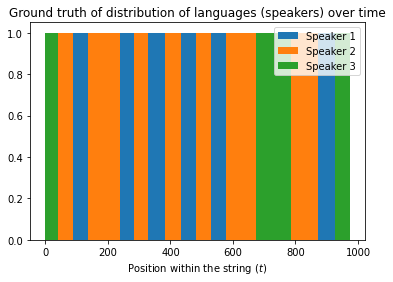

In [22]:
string, true_langs = generate_string(1000, 50)
print('Test string:', string[:100])
plot_ground_truth(true_langs)

In [9]:
def plot_posteriors(id, tm, em, obs):
    """Plots posteriors from HMM (`y`) as a stackplot"""
    # Get likelihoods
    y, _, _ = expect(id, tm, em, obs)
    y = y / y.sum(axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.stackplot(range(len(observations)), y, labels=[f'Speaker {i}' for i in range(1, 4)])
    plt.xlabel('Position within the string')
    plt.ylabel('Probability of each speaker')
    plt.legend()
    plt.show()

In [8]:
# Set new (shorter) variables to preserve initial values
tm = transition_matrix.copy()
em = emission_matrix.copy()
id = initial_distribution.copy()
obs = observations.copy()

Homogeneity Score: 0.4286842055470264


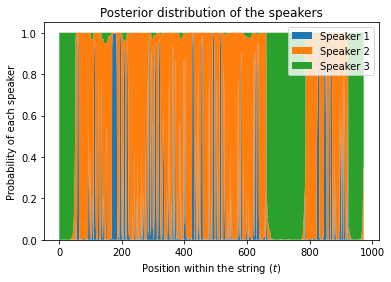

In [23]:
n_iter = 20

for _ in range(n_iter):
    id, tm, em = maximize(*expect(id, tm, em, obs))

print("Homogeneity Score:", homogeneity_score(true_langs, expect(id, tm, em, obs)[0].argmax(axis=1)))

plot_posteriors(id, tm, em, obs)